<a href="https://colab.research.google.com/github/jiin124/4th_kaggle_study/blob/main/6%EC%A3%BC%EC%B0%A8/%EB%8B%B9%EB%87%A8%EB%B3%91_%EC%98%88%EC%B8%A1_%EC%84%A0%ED%98%95%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/juyounghong/2021-ai-w4-p1-solution/data


- Pregnancies : 임신 횟수
- Glucose : 글루코오스(탄수화물 화합물)
- BloodPressure : 혈압
- SkinThickness : 피부 두께
- Insulin : 인슐린 수치
- BMI : BMI 지수
- DiabetesPedigreeFunction : 가족력
- Age : 나이
- Diabetes : 당뇨병일 경우 1 / 당뇨병이 아닐 경우 0

1. Loss 함수의 새로운 표현법
- 직접 cost 함수를 구현
- torch.nn.BCELoss
- torch.nn.BCEWithLogitsLoss
2. Scaler 사용
3. threshold 값을 임의로 조정

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

In [2]:
os.environ['KAGGLE_USERNAME']='jiinpp'
os.environ['KAGGLE_KEY']="b06d525a9f66198051ccb648b091778a"

In [3]:
!kaggle competitions download -c 2021-ai-w4-p1

  0% 0.00/1.48k [00:00<?, ?B/s]
100% 1.48k/1.48k [00:00<00:00, 2.63MB/s]
  0% 0.00/16.3k [00:00<?, ?B/s]
100% 16.3k/16.3k [00:00<00:00, 28.4MB/s]
  0% 0.00/7.06k [00:00<?, ?B/s]
100% 7.06k/7.06k [00:00<00:00, 8.78MB/s]


In [4]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
sample=pd.read_csv('submit.csv')

In [5]:
train.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Diabetes
0,1,95,60,18,58,23.9,0.260,22,0
1,5,105,72,29,325,36.9,0.159,28,0
2,0,135,68,42,250,42.3,0.365,24,1
3,4,131,68,21,166,33.1,0.160,28,0
4,1,103,30,38,83,43.3,0.183,33,0


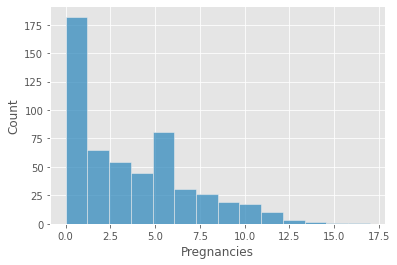

In [8]:
sns.histplot(data=train,x='Pregnancies')

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537 entries, 0 to 536
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               537 non-null    int64  
 1   Glucose                   537 non-null    int64  
 2   BloodPressure             537 non-null    int64  
 3   SkinThickness             537 non-null    int64  
 4   Insulin                   537 non-null    int64  
 5   BMI                       537 non-null    float64
 6   DiabetesPedigreeFunction  537 non-null    float64
 7   Age                       537 non-null    int64  
 8   Diabetes                  537 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 37.9 KB


In [6]:
from sklearn.preprocessing import RobustScaler

sc_X=RobustScaler()
X_train=pd.DataFrame(sc_X.fit_transform(train.drop(["Diabetes"],axis=1)),
                     columns=['Pregnancies', 'Glucose', 'BloodPressure', 
                               'SkinThickness', 'Insulin','BMI', 'DiabetesPedigreeFunction', 'Age'])
X_test = pd.DataFrame(sc_X.transform(test), 
                      columns=['Pregnancies', 'Glucose', 'BloodPressure', 
                               'SkinThickness', 'Insulin','BMI', 'DiabetesPedigreeFunction', 'Age'])
y_train = train.Diabetes


In [7]:
X_train.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,-0.4,-0.55,-0.750,-0.15625,0.170543,-0.835052,-0.307278,-0.411765
1,0.4,-0.30,0.000,0.18750,2.240310,0.505155,-0.579515,-0.058824
2,-0.6,0.45,-0.250,0.59375,1.658915,1.061856,-0.024259,-0.294118
3,0.2,0.35,-0.250,-0.06250,1.007752,0.113402,-0.576819,-0.058824
4,-0.4,-0.35,-2.625,0.46875,0.364341,1.164948,-0.514825,0.235294


In [8]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

(537, 8)
(231, 8)
(537,)


In [9]:
import pandas as pd
import numpy as np

import torch
import torch.optim as optim
import torch.nn.functional as F

torch.manual_seed(1)

In [10]:
X_train=torch.FloatTensor(np.array(X_train))
y_train=torch.FloatTensor(np.array(y_train))
X_test=torch.FloatTensor(np.array(X_test))

In [11]:
learning_rate=1e-2
epochs=3000


In [12]:
feature=8

W=torch.zeros((feature,1),requires_grad=True)
b=torch.zeros(1,requires_grad=True)

#클래스가 2개인경우 binary Cross Entropy Loss
loss=torch.nn.BCELoss()

#sigmoid 포함된 loss
loss=torch.nn.BCEWithLogitsLoss()

optimizer=optim.SGD([W,b],lr=learning_rate)

for epoch in range(epochs+1):
  hypothesis=torch.sigmoid(X_train.matmul(W)+b)
  cost=loss(X_train.matmul(W)+b,y_train.unsqueeze(1))

  optimizer.zero_grad()
  cost.backward()
  optimizer.step()

  if epoch%500==0:
    print('Epoch {:4d}/{} Cost: {:.6f}'.format(
        epoch,epochs,cost.item()
    ))


Epoch    0/3000 Cost: 0.693147
Epoch  500/3000 Cost: 0.527966
Epoch 1000/3000 Cost: 0.489346
Epoch 1500/3000 Cost: 0.474461
Epoch 2000/3000 Cost: 0.467575
Epoch 2500/3000 Cost: 0.464061
Epoch 3000/3000 Cost: 0.462151


In [13]:
hypothesis=torch.sigmoid(X_test.matmul(W)+b)
prediction=(hypothesis>=torch.FloatTensor([0.5])).type(torch.uint8)

In [14]:
prediction

tensor([[0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [1],
        [0],
        [1],
        [1],
        [0],
        [0],
        [1],
        [1],
        [0],
        [0],
        [1],
        [0],
        [1],
        [1],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],

In [16]:
for i,value in enumerate(prediction):
  sample['Diabetes'][i]=value.item()

sample.to_csv('output.csv',index=False)

In [17]:
sample

,ID,Diabetes
0,0,0
1,1,0
2,2,0
3,3,0
4,4,1
...,...,...
226,226,0
227,227,0
228,228,0
229,229,0
